## Exercise 2: Bias-variance trade-off and resampling techniques 

#### Overview of nature of the problem: n



In [1]:

import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from common import *
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:


np.random.seed(SEED_VALUE)
maxdegree = 15
n_bootstraps = 40
n = 20
x = np.sort(np.random.uniform(0, 1, n))
y = np.sort(np.random.uniform(0, 1, n))
x,y = np.meshgrid(x,y)
z = FrankeFunction(x,y) + 0.2*np.random.normal(0, size = n)
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(20, 20)


Testing bootstrap function

Looping trhough polynomials up to 15 with 40: 100%|██████████| 15/15 [00:00<00:00, 26.85it/s]


Elapsed time 571.9481ms in function bootstrap


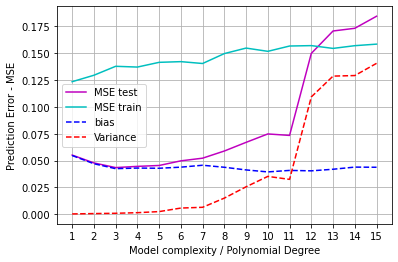

In [3]:
polydegree = np.arange(1, maxdegree+1)
MSE_test, MSE_train, bias, variance = bootstrap(x, y, z, maxdegree, n_bootstraps, OLS())

plt.plot(polydegree, MSE_test,"m", label='MSE test')
plt.plot(polydegree, MSE_train,"c", label='MSE train')
plt.plot(polydegree, bias,"b--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')
#plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.xticks(polydegree)
plt.grid(True)
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX2}model_complexity_using_bootstrap_function.pdf")
plt.show()

In [4]:
MSE_test = np.zeros(maxdegree)
MSE_train = np.zeros(maxdegree)
polydegree = np.arange(1, maxdegree+1)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
z_flat = z.ravel().reshape(-1,1)

Looping through polynomials up to 15 degrees with 40 bootstraps: 100%|██████████| 15/15 [00:00<00:00, 25.13it/s]


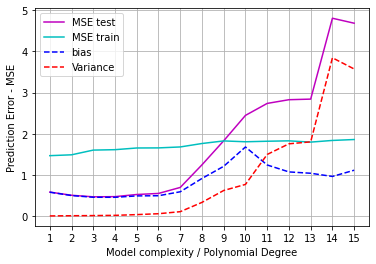

In [5]:

for degree in tqdm(range(1, maxdegree+1), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
    X = create_X(x, y, n=degree)

    # Train test split
    X_train, X_test, z_train, z_test = prepare_data(X, z_flat, test_size=0.2, shuffle=True, scale_X=True, scale_t=True, random_state=SEED_VALUE)

    model = OLS()
    z_hat_trains, z_hat_tests = bootstrapping(X_train, z_train, X_test, z_test, n_bootstraps, model, keep_intercept=True)

    MSE_test[degree-1] = np.mean( np.mean((z_test - z_hat_tests)**2, axis=1, keepdims=True ))
    MSE_train[degree-1] = np.mean( np.mean((z_train - z_hat_trains)**2, axis=1, keepdims=True ))
    bias[degree-1] = np.mean( (z_test - np.mean(z_hat_tests, axis=1, keepdims=True))**2 )
    variance[degree-1] = np.mean( np.var(z_hat_tests, axis=1, keepdims=True))

plt.plot(polydegree, MSE_test,"m", label='MSE test')
plt.plot(polydegree, MSE_train,"c", label='MSE train')
plt.plot(polydegree, bias,"b--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')
#plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error - MSE")
plt.xticks(polydegree)
plt.grid(True)
plt.legend()
plt.savefig(f"{REPORT_FIGURES}{EX6_2}model_complexity_using_bootstrap.pdf")
plt.show()

In [6]:

#TODO: Number of bootstraps? 
n_bootstraps = 40
MSE_test = np.zeros(maxdegree)
MSE_train = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
#for each degree of poly:


for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {n} degrees with {n_bootstraps} bootstraps: "):
    #model = LinearRegression()
    #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
    X = create_X(x, y, n=degree)
    #print(f"X.shape:{X.shape}")    
    # X_train, X_test, y_train, y_test = train_test_split(X, z.reshape(-1,1), test_size=0.2, shuffle=True)
    
    X_train, X_test, y_train, y_test = prepare_data(X, z.reshape(-1,1), scale_X=False, scale_t=False, zero_center=False)

    #print(z.shape)
    #reshape for broadcasting in MSE_test and MSE_val  
    y_test_ = np.reshape(y_test, newshape=(y_test.shape[0],1))
    #reshape for broadcasting in MSE_test and MSE_val  
    y_train_ = np.reshape(y_train, newshape=(y_train.shape[0],1))

    #y_train = np.reshape(y_train, newshape=(y_train.shape[0],1))
    #TODO: why scale?!?

    # Commenting out the standard scaler, to try an implementation based on manual scaling as presented in the lecture notes
    #scaler = StandardScaler()
    #scaler.fit(X_train)
    #X_train_scaled = scaler.transform(X_train)
    #X_test_scaled = scaler.transform(X_test)
    X_train = X_train - np.mean(X_train,axis=0)
    X_test = X_test - np.mean(X_test,axis=0)
    y_train = y_train - np.mean(y_train,axis=0)
    y_test = y_test - np.mean(y_test,axis=0)
    y_pred = np.empty((y_test.shape[0], n_bootstraps))
    y_fit = np.empty((y_train.shape[0], n_bootstraps))
    model = OLS()
    
    for i in range(n_bootstraps):
        #bootstrap:
        x_, y_ = resample(X_train, y_train)
        #fit model to x_,y_ sample:
        y_hat_train = model.fit(x_, y_, SVDfit=False)
        t_hat_test = model.predict(X_test)
        #clf = LinearRegression().fit(x_, y_)
        #fit model and predict on test data:
        y_pred[:, i] = y_hat_train.ravel()
        #predict on train data:
        y_fit[:,i] = t_hat_test.ravel()
        

    polydegree[degree] = degree
    #print(f"y_test.shape:{y_test.shape}, y_pred.shape{y_pred.shape}")
    MSE_test[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True ))
    MSE_train[degree] = np.mean( np.mean((y_train - y_fit)**2, axis=1, keepdims=True ))
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True))
    
    
plt.plot(polydegree, MSE_test,"m", label='MSE_test')
plt.plot(polydegree, MSE_train,"c", label='MSE_train')

plt.plot(polydegree, bias,"b--", label='bias')
plt.plot(polydegree, variance,"r--", label='Variance')
#plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error")

plt.grid(True)
plt.legend()
plt.show()

Looping through polynomials up to 20 degrees with 40 bootstraps:   0%|          | 0/15 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

# Studying bias-variance tradeoff as dependance on the number of datpoints
The following section will create datasets with an increasing number of datapoints. The purpouse of this analysis is to study how the bias-variance tradeoff for Ordinary Least squares varies as a function of the number of datapoints. This is an addendum to the previous analysis where we studied the bias-variance tradeoff as a function of the model complexity. 

In [7]:


n_list = [10, 20, 30, 40, 50]
n_bootstraps = 20
maxdegree = 12
polydegree = np.arange(maxdegree)

for n in n_list:
    x = np.sort(np.random.uniform(0,1,n))
    y = np.sort(np.random.uniform(0,1,n))
    x,y = np.meshgrid(x,y)
    z = FrankeFunction(x, y) + 0.2*np.random.normal(0, size = n)

    MSE_test_n = np.zeros(maxdegree)
    MSE_train_n = np.zeros(maxdegree)
    variance_n = np.zeros(maxdegree)
    bias_n = np.zeros(maxdegree)

    for degree in tqdm(range(maxdegree), desc = f"Looping through polynomials up to {maxdegree} degrees with {n_bootstraps} bootstraps: "):
        model = LinearRegression()
        #model= make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False)) 
        X = create_X(x, y, n=degree)    
        X_train, X_test, y_train, y_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)

        #reshape for broadcasting in MSE_test and MSE_val  
        y_test_ = np.reshape(y_test, newshape=(y_test.shape[0],1))
        #reshape for broadcasting in MSE_test and MSE_val  
        y_train_ = np.reshape(y_train, newshape=(y_train.shape[0],1))

        #y_train = np.reshape(y_train, newshape=(y_train.shape[0],1))
        #TODO: why scale?!?

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        y_pred = np.empty((y_test.shape[0], n_bootstraps))
        y_fit = np.empty((y_train.shape[0], n_bootstraps))
    
        for i in range(n_bootstraps):
            #bootstrap:
            x_, y_ = resample(X_train_scaled, y_train)
            #fit model to x_,y_ sample:
            #print(f"y_.shape : {y_.shape}")
            model.fit(x_, y_, SVDfit=False)
            #fit model and predict on test data:
            y_pred[:, i] = model.predict(X_test_scaled).ravel()
            #predict on train data:
            y_fit[:,i] = model.predict(X_train_scaled).ravel()
        

        #polydegree[degree] = degree
   
        MSE_test_n[degree] = np.mean( np.mean((y_test_ - y_pred)**2, axis=1, keepdims=True) )
        MSE_train_n[degree] = np.mean( np.mean((y_train_ - y_fit)**2, axis=1, keepdims=True) )
        bias_n[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance_n[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True))
    
    plt.plot(polydegree, MSE_test_n,"m", label='MSE_test')
    plt.plot(polydegree, MSE_train_n,"c", label='MSE_train')

    plt.plot(polydegree, bias_n,"g--", label='bias')
    plt.plot(polydegree, variance_n,"r--", label='Variance')

    plt.title(f"Bias-Variance tradeoff for n={n} datapoints")
    plt.xlabel("Model complexity / Polynomial Degree")
    plt.ylabel("Prediction Error")

    plt.grid(True)
    plt.legend()
    plt.show()

    


Looping through polynomials up to 12 degrees with 20 bootstraps:   0%|          | 0/12 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)